In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 

# Gensim
import spacy
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis  

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

Loading BokehJS ...

In [59]:
train_df = pd.read_csv('train.csv')

In [60]:
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    # самые частые слова
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('utf-8').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

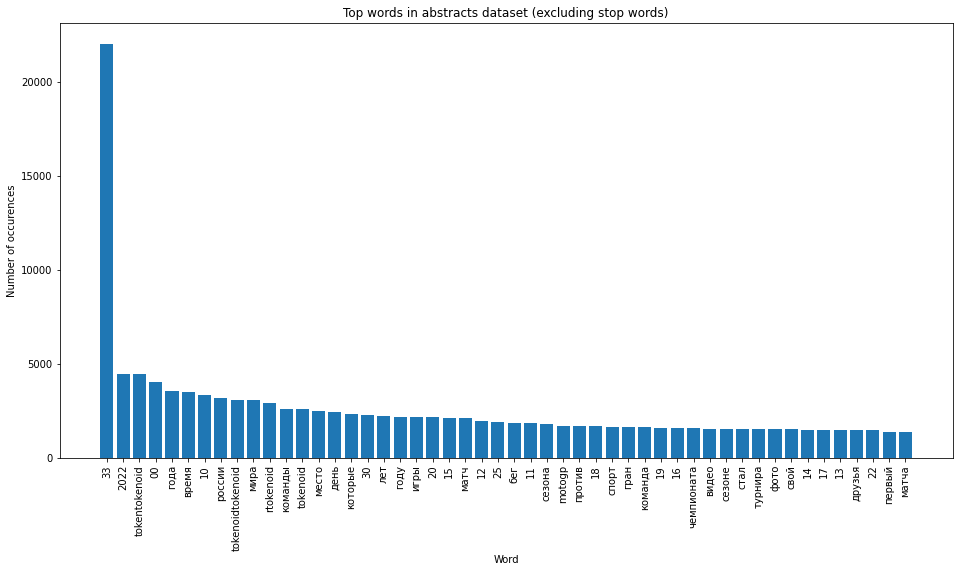

In [61]:
count_vectorizer = CountVectorizer(stop_words=russian_stopwords)
words, word_values = get_top_n_words(n_top_words = 50,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=train_df['text'])

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in abstracts dataset (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

In [3]:
russian_stopwords = stopwords.words("russian")
russian_stopwords += ['это', 'очень', 'сегодня', 'также', 'который', 'просто',
                      'всем', 'нужно', 'будет', 'будут', 'нам', 'поэтому']
nlp = spacy.load('ru_core_news_sm')

In [4]:
df = train_df.copy()

In [5]:
def remove_emoji(string):
    """
    Удаление эмоджи из текста
    """
    emoji_pattern = re.compile("["u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u'\U00010000-\U0010ffff'
                               u"\u200d"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\u3030"
                               u"\ufe0f"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

def remove_extra_marks(abstract):
    "Return the abstracts after remvoing extra marks"
    extra_keys = ["’","—","”","“","-","–"]
    abstract_tokens = word_tokenize(abstract) 
    filtered_abstract = [word for word in abstract_tokens if not word in extra_keys] 
    return " ".join(filtered_abstract)

def replace_symbols(text,dic):
    "Return the abstracts after remvoing symbols in dic"
    for i, j in dic.items():
        text = text.replace(i, j)
    return text

def remove_stopwords(text, stop_words = russian_stopwords):
    "Return the text after remvoing stopwords"
    article_tokens = word_tokenize(text) 
    filtered_article = [word for word in article_tokens if not word in stop_words] 
    return " ".join(filtered_article)

def remove_ascii(text):
    for i in text:
        if 33 < ord(i) < 128:
            text = text.replace(i,'')
    return text.strip()


def lemmatize(abstract):
    """Return text after performing the lemmatization"""
    doc = nlp(abstract)
    #tokens = [token for token in doc]
    return  " ".join([token.lemma_ for token in doc])

def split_capital(text):
    text = text.split()
    res = ''
    for i in text:
        x = re.findall(r'[A-ZА-Я][a-zа-я]+', i)
        res += ' '.join(x) + ' ' if x else i + ' '
    return res.strip()


def preprocessing(abstracts):
    "Make abstracts preprocessing"
    d = { '\n': "", '\t': "", '\xa0':' '}
    abstracts = abstracts.apply(lambda x: replace_symbols(x,d))
    # remove emoji
    abstracts = abstracts.apply(remove_emoji)
    # lowcase
    #abstracts = abstracts.apply(lambda t : t.lower())
    #removing punctuations 
    abstracts = abstracts.apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
    # remove formulas like $...$
    abstracts = abstracts.apply(lambda x: re.sub(r'\$.+\$', '', x)) 
    #removing digits
    abstracts = abstracts.apply(lambda x: re.sub('\w*\d\w*','', x))
    #removing extra marks
    abstracts = abstracts.apply(remove_extra_marks)
    #removing words with length <=2
    abstracts = abstracts.apply(lambda x: re.compile(r'\W*\b\w{1,2}\b').sub('', x))
    #remove latin symbols
    #abstracts = abstracts.apply(remove_ascii)
    #lemmatization
    #abstracts = abstracts.apply(lemmatize)
    #removing stopwords
    #abstracts = abstracts.apply(remove_stopwords)
    abstracts = abstracts.apply(split_capital)
    return abstracts

In [6]:
%%time
df['text']=preprocessing(df['text'])

Wall time: 10.5 s


In [7]:
from nltk.tokenize import word_tokenize

def tokenize(text):
    return word_tokenize(text)

tokens = df['text'].apply(tokenize)

In [8]:
def remove_token_words(text:list):
    new_text=[]
    for i in text:
        if 'token' not in i:
            new_text.append(i)
    return new_text

for i in range(len(tokens)):
    tokens[i] = remove_token_words(tokens[i])

In [9]:
def lower_text(text:list):
    return [x.lower() for x in text]

for i in range(len(tokens)):
    tokens[i] = lower_text(tokens[i])

In [10]:
docs = []
for i in tokens:
    docs.append(" ".join(i))

In [11]:
df['clean_text'] = docs
df

,oid,category,text,clean_text
0,365271984,winter_sport,Волшебные фото Виктория Поплавская Евгения Мед...,волшебные фото виктория поплавская евгения мед...
1,503385563,extreme,Возвращение подземелье Треша Эйфория тупости ж...,возвращение подземелье треша эйфория тупости ж...
2,146016084,football,Лучшие чешские вратари Доминик Доминатор Гашек...,лучшие чешские вратари доминик доминатор гашек...
3,933865449,boardgames,Rtokenoid валрак решил нас подкормить сильно с...,валрак решил нас подкормить сильно свежими слу...
4,713550145,hockey,Шестеркин затаскивает Рейнджерс финал Восточно...,шестеркин затаскивает рейнджерс финал восточно...
...,...,...,...,...
38735,910636962,autosport,битная буря снова накрыла пикселями автомобиль...,битная буря снова накрыла пикселями автомобиль...
38736,669736851,autosport,Ира Сидоркова объясняет как сказалась машине р...,ира сидоркова объясняет как сказалась машине р...
38737,558919241,tennis,ракетка мира хорват Марин Чилич обыграл испанц...,ракетка мира хорват марин чилич обыграл испанц...
38738,776944963,volleyball,Стал известен календарь мужской сборной России...,стал известен календарь мужской сборной россии...


In [12]:
%%time
#removing stopwords
df['clean_text'] = df['clean_text'].apply(remove_stopwords)
#lemmatization
df['clean_text'] = df['clean_text'].apply(lemmatize)

Wall time: 8min 52s


In [18]:
cat = {'winter_sport': 0, 'extreme': 1, 'football': 2, 'boardgames': 3,
       'hockey': 4, 'esport': 5, 'athletics': 6, 'motosport': 7, 'basketball': 8,
       'tennis': 9, 'autosport': 10, 'martial_arts': 11, 'volleyball': 12}
df.replace({'category':cat}, inplace= True)

In [15]:
#df.to_csv('preproc_09_12.csv', index=False)

In [19]:
X = df['clean_text'] 
y = df['category']
print(X.shape, y.shape)

(38740,) (38740,)


In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split

SEED=42
X = df['clean_text']
y = df['category']
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.2, random_state=SEED)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(30992,) (30992,)
(7748,) (7748,)


In [69]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', LinearSVC())
])
nb.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LinearSVC())])

In [70]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,f1_score,plot_confusion_matrix,make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score

def print_res(y_test, answers_pred):
    print(f'Accuracy: {accuracy_score(y_test, answers_pred)}')
    print(f'Precision: {precision_score(y_test, answers_pred, average="micro")}')
    print(f'Recall: {recall_score(y_test, answers_pred,average="micro")}')
    print(f'F1: {f1_score(y_test, answers_pred,average="micro")}')
    
pred = nb.predict(X_test)
print_res(y_test,pred)

Accuracy: 0.8710635002581312
Precision: 0.8710635002581312
Recall: 0.8710635002581312
F1: 0.8710635002581312


Рассмотрим полученные результаты

In [55]:
dfnew = df[df.index.isin(X_test.to_frame().index)]

In [57]:
dfnew.insert(1,column = 'pred', value=pred)

In [71]:
dfnew[dfnew['oid'] == 713550145]

,oid,pred,category,text,clean_text
4,713550145,3,4,Шестеркин затаскивает Рейнджерс финал Восточно...,шестеркин затаскивать рейнджерс финал восточны...
1348,713550145,12,4,Кэйн хочет завершить карьеру Чикаго Это было п...,кэйн хотеть завершить карьера чикаго привилеги...
22206,713550145,12,4,Капризов набрал матче Ванкувером него очков ма...,капризов набрать матч ванкувер очко матч резул...
31166,713550145,3,4,Источник вопрос лишении ФХР членства ИИХФ подн...,источник вопрос лишение фхр членство иихф подн...


Проверим количество тематик у каждого автора

In [73]:
d = {}
for user in df.oid.unique():
    d[user] = len(df[df['oid'] == user]['category'].unique())
max(d.values())

1

Получается, что каждый автор пишет только на определенную тематику. Будем использовать это предположение